In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load and view data
data = pd.read_csv('ppp sample.csv')
print(f"Shape of the data is: {data.shape}")
data.head()

Shape of the data is: (103, 10)


,LoanAmount,City,State,Zip,NAICSCode,BusinessType,DateApproved,Lender,CD,LoanRange
0,18700,PONDER,TX,76259,111219,Corporation,4/13/2020,AccessBank Texas,TX-26,1
1,6400,FLOWER MOUND,TX,75028,115310,Corporation,8/7/2020,AccessBank Texas,TX-26,1
2,20800,KRUM,TX,76249,211130,Corporation,4/14/2020,AccessBank Texas,TX-26,1
3,3800,KRUM,TX,76249,212321,Sole Proprietorship,4/15/2020,AccessBank Texas,TX-26,1
4,53300,ARGYLE,TX,76226,221310,Self-Employed Individuals,4/14/2020,AccessBank Texas,TX-26,3


In [3]:
# investigate rows with null values
data[data.isnull().any(axis=1)]

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,DateApproved,Lender,CD,LoanRange


In [4]:
# only take rows of businesses that CD is not null

data = data[data['CD'].notna()]
data.head()

#drop rows with NA cities
data = data[data['City'].notna()]

# drop rows with NA NAICS code
data = data[data['NAICSCode'].notna()]

#drop rows with NA business type
data = data[data['BusinessType'].notna()]

data.isnull().sum()

data.shape

data.head()

data['NAICSCode'] = data['NAICSCode'].astype(int)

data

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,DateApproved,Lender,CD,LoanRange
0,18700,PONDER,TX,76259,111219,Corporation,4/13/2020,AccessBank Texas,TX-26,1
1,6400,FLOWER MOUND,TX,75028,115310,Corporation,8/7/2020,AccessBank Texas,TX-26,1
2,20800,KRUM,TX,76249,211130,Corporation,4/14/2020,AccessBank Texas,TX-26,1
3,3800,KRUM,TX,76249,212321,Sole Proprietorship,4/15/2020,AccessBank Texas,TX-26,1
4,53300,ARGYLE,TX,76226,221310,Self-Employed Individuals,4/14/2020,AccessBank Texas,TX-26,3
...,...,...,...,...,...,...,...,...,...,...
98,17841,Littlefield,TX,79339,311811,Partnership,6/30/2020,Accion,TX-19,1
99,12200,Houston,TX,77065,311811,Sole Proprietorship,6/28/2020,Accion,TX-07,1
100,13700,Uvalde,TX,78801,312112,Limited Liability Company(LLC),7/22/2020,Accion,TX-23,1
101,19950,North Richland Hills,TX,76180,312120,Limited Liability Company(LLC),6/15/2020,Accion,TX-12,1


In [5]:
## read in data for NAICS code

naics = pd.read_csv('US-Business-Profiles-By-Sales-and-Employees (2).csv')

naics.head()

,NAICS 1 Code,NAICS 1 Description
0,111110,Soybean Farming
1,111120,Oilseed (except Soybean) Farming
2,111130,Dry Pea and Bean Farming
3,111140,Wheat Farming
4,111150,Corn Farming


In [6]:
naics.dtypes
naics[naics.isnull().any(axis=1)]


naics['NAICS 1 Code'] = naics['NAICS 1 Code'].astype(int)

naics

,NAICS 1 Code,NAICS 1 Description
0,111110,Soybean Farming
1,111120,Oilseed (except Soybean) Farming
2,111130,Dry Pea and Bean Farming
3,111140,Wheat Farming
4,111150,Corn Farming
...,...,...
1040,926140,Regulation of Agricultural Marketing and Commo...
1041,926150,"Regulation, Licensing, and Inspection of Misce..."
1042,927110,Space Research and Technology
1043,928110,National Security


In [7]:
## merge tables 

loan_data = pd.merge(data, naics, left_on='NAICSCode', right_on='NAICS 1 Code')


# drop categorical columns
loan_data_top = loan_data.drop(columns=['City', 'DateApproved', 'CD', 'LoanAmount', 'BusinessType', 'State', 'NAICS 1 Description'], axis=1)

# loan_data = pd.get_dummies(data, columns=["BusinessType"])

loan_data_top.head()


,Zip,NAICSCode,Lender,LoanRange,NAICS 1 Code
0,76259,111219,AccessBank Texas,1,111219
1,75028,115310,AccessBank Texas,1,115310
2,76249,211130,AccessBank Texas,1,211130
3,76249,212321,AccessBank Texas,1,212321
4,76226,221310,AccessBank Texas,3,221310


In [8]:
# drop lenders with loans of 5 or more
counts = loan_data_top['Lender'].value_counts()

loan_data_top = loan_data_top.loc[loan_data_top['Lender'].isin(counts.index[counts > 5])]
loan_data_top.shape

loan_data_top.head()


,Zip,NAICSCode,Lender,LoanRange,NAICS 1 Code
0,76259,111219,AccessBank Texas,1,111219
1,75028,115310,AccessBank Texas,1,115310
2,76249,211130,AccessBank Texas,1,211130
3,76249,212321,AccessBank Texas,1,212321
4,76226,221310,AccessBank Texas,3,221310


In [9]:
# Assign X (data) and y(target)
X = loan_data_top.drop("Lender", axis=1)
y = loan_data_top["Lender"]
print(X.shape, y.shape)

(103, 4) (103,)


In [10]:
# Split our data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [11]:
# Create a logistic Regression Model
classifier = LogisticRegression()
classifier

LogisticRegression()

In [12]:
# Fit model using the training data
classifier.fit(X_train, y_train)

LogisticRegression()

In [13]:
# evaluate the model's performance using the test data
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.6623376623376623
Testing Data Score: 0.5384615384615384


In [14]:
# Make predictions
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   ['AccessBank Texas' 'Accion' 'AccessBank Texas' 'AccessBank Texas'
 'Accion' 'AccessBank Texas' 'AccessBank Texas' 'AccessBank Texas'
 'AccessBank Texas' 'AccessBank Texas']
First 10 Actual labels: ['Accion', 'AccessBank Texas', 'Accion', 'Accion', 'Accion', 'AccessBank Texas', 'Accion', 'Accion', 'AccessBank Texas', 'AccessBank Texas']


In [15]:
# View predictions along with their probabilities of being within each class 
##  this will be the difficult part of our project because data is not binary like example: male/female
probs = classifier.predict_proba(X_test)
pred_df = pd.DataFrame({
    "Prediction": predictions, 
    "Actual": y_test, 
    "P(Female)": [p[0] for p in probs], 
    "P(Male)": [p[1] for p in probs]
    }).reset_index(drop=True)

pred_df.head(10)

,Prediction,Actual,P(Female),P(Male)
0,AccessBank Texas,Accion,0.534832,0.465168
1,Accion,AccessBank Texas,0.160953,0.839047
2,AccessBank Texas,Accion,0.542506,0.457494
3,AccessBank Texas,Accion,0.533929,0.466071
4,Accion,Accion,0.436384,0.563616
5,AccessBank Texas,AccessBank Texas,0.534308,0.465692
6,AccessBank Texas,Accion,0.540750,0.459250
7,AccessBank Texas,Accion,0.542287,0.457713
8,AccessBank Texas,AccessBank Texas,0.531706,0.468294
9,AccessBank Texas,AccessBank Texas,0.534386,0.465614


In [16]:
# Model Evaluation
# Create a Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,predictions)

array([[12,  2],
       [10,  2]], dtype=int64)

In [17]:
# Label the confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(f"True Neg: {tn}   False Pos: {fp}")
print(f"False Neg: {fn}  True Pos: {tp}")

True Neg: 12   False Pos: 2
False Neg: 10  True Pos: 2


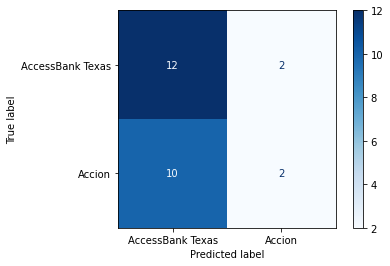

In [18]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues")

In [19]:
# Precision and Recall
### we don't technically have a "positive" label, like we would if we were classifying emails as Spam, or patients as having cancer. 
## This means that we need to tell our precision and recall functions which class label we want to consider to be our "positive" class i.e. which lender
from sklearn.metrics import precision_score, recall_score, f1_score

In [20]:
## Random tests of lenders first test is AccessBank Texas, the lender with the most loans
precision_score(y_test, predictions, pos_label="AccessBank Texas")

0.5454545454545454

In [21]:
## Random tests of lenders second test is Accion, random test of lender with lower loan count of 10 loans
precision_score(y_test, predictions, pos_label="Accion")

0.5

In [22]:
#  what is the harmonic mean of AccessBank Texas from first test
f1_score(y_test, predictions, pos_label="AccessBank Texas")

0.6666666666666665

In [23]:
#  what is the harmonic mean of Accion from second test
f1_score(y_test, predictions, pos_label="Accion")

0.25